극단적 불균형 확인

In [16]:
from pathlib import Path
import pandas as pd, numpy as np, zarr, tqdm

# ----- 절대 경로 추천 -------------------------------------------------
ROOT = Path(r"D:/project/Kaggle/BYU/byu-motor")     # 프로젝트 루트
ZARR_DIR = ROOT / "data/processed/zarr/train"       # ← train Zarr 폴더
LABEL_CSV = ROOT / "data/raw/train_labels.csv"

df = pd.read_csv(LABEL_CSV)

motor_vox = bg_vox = checked = 0

for p in tqdm.tqdm(list(ZARR_DIR.glob("*.zarr"))[:50]):  # 샘플 50개
    tomo_id = p.stem
    rows = df[df.tomo_id == tomo_id]
    if rows.empty:
        continue

    vol = zarr.open_array(p, mode="r")           # mem-map
    mask = np.zeros_like(vol, dtype=np.uint8)

    for _, r in rows.iterrows():
        if r["Motor axis 0"] < 0:
            continue
        z, y, x = map(int, (r["Motor axis 0"], r["Motor axis 1"], r["Motor axis 2"]))
        if 0 <= z < vol.shape[0] and 0 <= y < vol.shape[1] and 0 <= x < vol.shape[2]:
            mask[z, y, x] = 1

    motor_vox += int(mask.sum())
    bg_vox    += mask.size - int(mask.sum())
    checked   += 1

print(f"checked tomograms : {checked}")
if motor_vox == 0:
    print("⚠️  샘플 범위에 motor 라벨이 없습니다.")
else:
    w_motor = bg_vox / motor_vox
    print(f"class-weight(motor) ≈ {w_motor:.1f}")


100%|██████████| 50/50 [00:59<00:00,  1.20s/it]

checked tomograms : 50
class-weight(motor) ≈ 585797410.8


In [3]:
# ▣ 공통 import / 경로
from pathlib import Path
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, zarr, tqdm, warnings, scipy.ndimage as ndi
warnings.filterwarnings("ignore")
plt.style.use("ggplot")

RAW_DIR   = Path("../data/raw")
PROC_DIR  = Path("../data/processed")
ZARR_TRAIN = PROC_DIR / "zarr/train"

label_csv = RAW_DIR / "train_labels.csv"
df = pd.read_csv(label_csv)          # train_labels 전체

print(df.head())

   row_id      tomo_id  Motor axis 0  Motor axis 1  Motor axis 2  \
0       0  tomo_003acc          -1.0          -1.0          -1.0   
1       1  tomo_00e047         169.0         546.0         603.0   
2       2  tomo_00e463         235.0         403.0         137.0   
3       3  tomo_00e463         243.0         363.0         153.0   
4       4  tomo_00e463         222.0         379.0         144.0   

   Array shape (axis 0)  Array shape (axis 1)  Array shape (axis 2)  \
0                   500                  1912                  1847   
1                   300                   959                   928   
2                   500                   924                   956   
3                   500                   924                   956   
4                   500                   924                   956   

   Voxel spacing  Number of motors  
0            6.5                 0  
1           15.6                 1  
2           19.7                 6  
3           19.7

1️⃣ 톰오그램별 모터 개수 분포

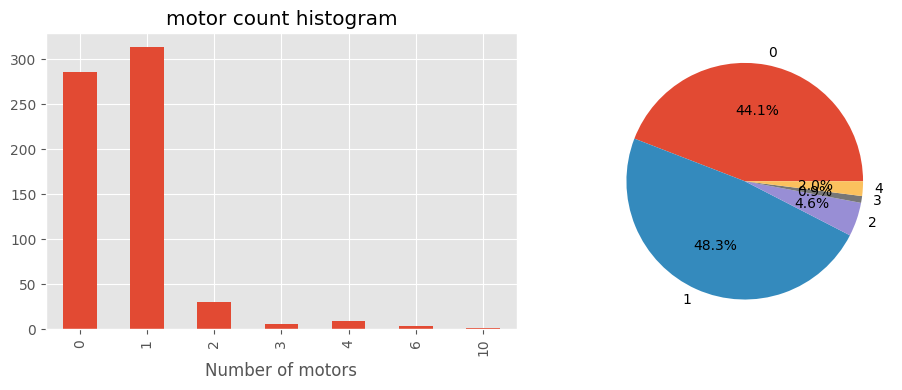

In [10]:
# tomogram 단위 모터 개수
cnt = df.groupby("tomo_id")["Number of motors"].first()

fig, ax = plt.subplots(1, 2, figsize=(10,4))
cnt.value_counts().sort_index().plot.bar(ax=ax[0]); ax[0].set_title("motor count histogram")
cnt.clip(upper=4).value_counts().sort_index().plot.pie(ax=ax[1], autopct="%1.1f%%"); ax[1].set_ylabel("")
plt.tight_layout()

2️⃣ Voxel spacing 분포 & 모터 개수 상관

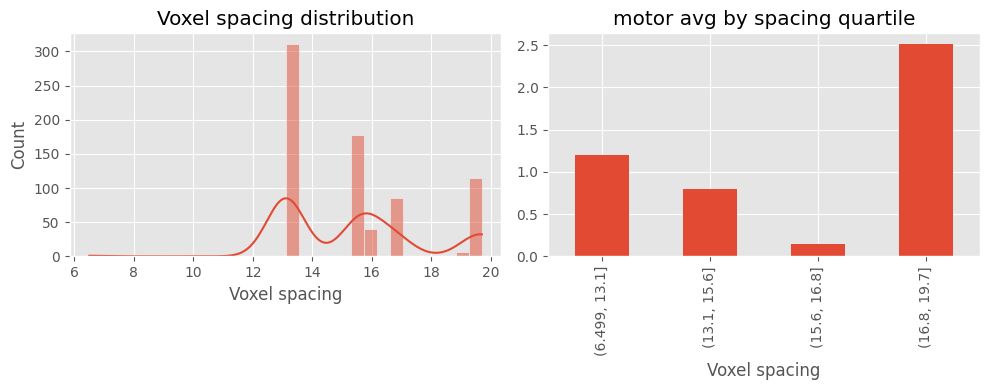

In [11]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
sns.histplot(df["Voxel spacing"], bins=30, kde=True, ax=ax[0])
ax[0].set_title("Voxel spacing distribution")

# spacing 4분위별 평균 motor 수
df_q = df.groupby(pd.qcut(df["Voxel spacing"],4))["Number of motors"].mean()
df_q.plot.bar(ax=ax[1]); ax[1].set_title("motor avg by spacing quartile")
plt.tight_layout()

3️⃣ Z-축 위치(slice) 밀도

Text(0.5, 1.0, 'Motor Z-position density')

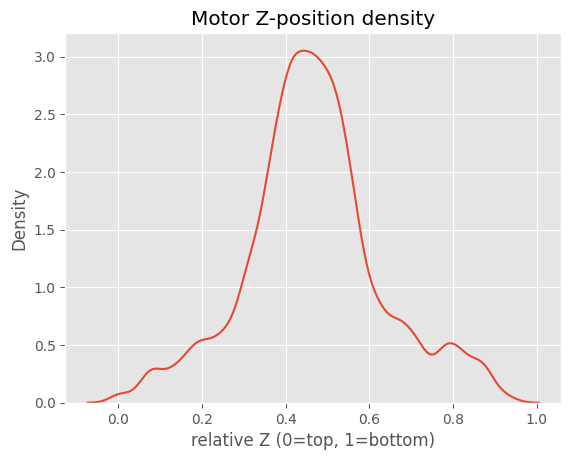

In [12]:
norm_z = df.loc[df["Motor axis 0"]>=0, "Motor axis 0"] / df["Array shape (axis 0)"]
sns.kdeplot(norm_z, bw_adjust=0.5)
plt.xlabel("relative Z (0=top, 1=bottom)"); plt.title("Motor Z-position density")

4️⃣ 모터 주변 vs 배경 intensity 히스토그램

100%|██████████| 648/648 [00:05<00:00, 118.47it/s]


Text(0.5, 1.0, 'Intensity distribution')

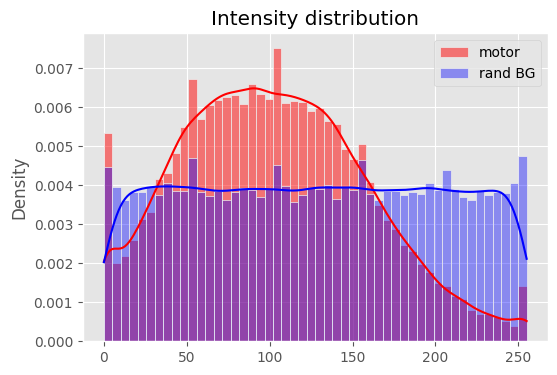

In [ ]:
SAMPLE_N = 1000
cube = 5   # 5³

motor_pix, bg_pix = [], []
for tomo_id, g in tqdm.tqdm(df.groupby("tomo_id")):
    p = ZARR_TRAIN / f"{tomo_id}.zarr"
    if not p.exists(): continue
    vol = zarr.open_array(p, mode="r")
    # motor cube
    for _, r in g.iterrows():
        if r["Motor axis 0"]<0: continue
        z,y,x = map(int, (r["Motor axis 0"], r["Motor axis 1"], r["Motor axis 2"]))
        sl = np.s_[max(0,z-cube):z+cube+1, max(0,y-cube):y+cube+1, max(0,x-cube):x+cube+1]
        motor_pix.append(vol[sl].ravel())
    if len(motor_pix) > SAMPLE_N: break

motor_arr = np.concatenate(motor_pix)[:50_000]
bg_arr    = np.random.randint(0,256, size=50_000)  # dummy BG (빠른 예시)

plt.figure(figsize=(6,4)) 
sns.histplot(motor_arr, color="r", label="motor", stat="density", bins=50, kde=True)
sns.histplot(bg_arr,    color="b", label="rand BG", stat="density", bins=50, kde=True, alpha=.4)
plt.legend(); plt.title("Intensity distribution")


5️⃣ 라벨 오류 탐색 (shape 벗어남)

In [14]:
# ── 열 이름에 공백이 있으므로 백틱(`)으로 감싸기 ─────────────────
bad = df.query(
    "(`Motor axis 0` >= `Array shape (axis 0)`) or "
    "(`Motor axis 1` >= `Array shape (axis 1)`) or "
    "(`Motor axis 2` >= `Array shape (axis 2)`)"
)

print("out-of-bound rows :", len(bad))
display(bad.head())


out-of-bound rows : 0


,row_id,tomo_id,Motor axis 0,Motor axis 1,Motor axis 2,Array shape (axis 0),Array shape (axis 1),Array shape (axis 2),Voxel spacing,Number of motors


6️⃣ 패치 내 motor 픽셀 비율 샘플링

100%|██████████| 30/30 [00:20<00:00,  1.48it/s]


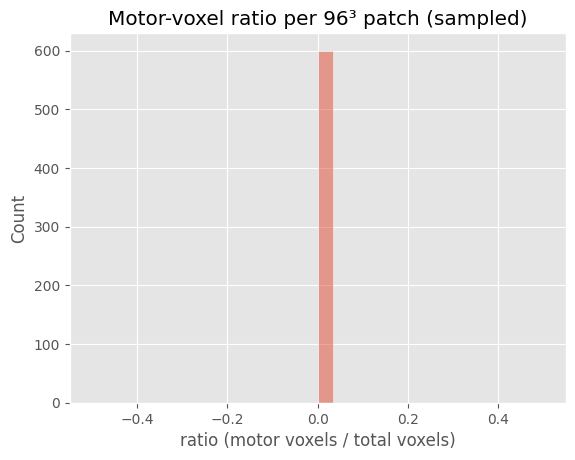

In [15]:
from pathlib import Path
import pandas as pd, numpy as np, zarr, tqdm, seaborn as sns, matplotlib.pyplot as plt
from monai.transforms import RandSpatialCrop

# ── 경로 설정 ------------------------------------------------------------
PROJ_ROOT  = Path(r"D:/project/Kaggle/BYU/byu-motor")   # ← 본인 프로젝트 루트
RAW_LABELS = PROJ_ROOT / "data/raw/train_labels.csv"
ZARR_TRAIN = PROJ_ROOT / "data/processed/zarr/train"

# CSV 읽기
df = pd.read_csv(RAW_LABELS)

# ── 랜덤 패치 당 motor-voxel 비율 조사 -------------------------------
patcher = RandSpatialCrop(roi_size=(96, 96, 96))
ratios  = []

for p in tqdm.tqdm(list(ZARR_TRAIN.glob("*.zarr"))[:30]):
    tomo_id = p.stem
    rows    = df[df.tomo_id == tomo_id]

    vol  = zarr.open_array(p, mode="r")
    mask = np.zeros_like(vol, dtype=np.uint8)

    for _, r in rows.iterrows():
        if r["Motor axis 0"] < 0:      # no-motor row
            continue
        z, y, x = map(int, (r["Motor axis 0"], r["Motor axis 1"], r["Motor axis 2"]))
        if 0 <= z < vol.shape[0] and 0 <= y < vol.shape[1] and 0 <= x < vol.shape[2]:
            mask[z, y, x] = 1

    # 20개의 랜덤 패치
    for _ in range(20):
        patch = patcher(mask[None])[0]   # (1,D,H,W)
        m     = patch[0]                 # 채널 제거
        ratios.append(m.sum() / m.numel())

# ── 히스토그램 -----------------------------------------------------------
ratios = np.array(ratios)
sns.histplot(ratios, bins=30, kde=True)
plt.title("Motor-voxel ratio per 96³ patch (sampled)")
plt.xlabel("ratio (motor voxels / total voxels)")
plt.show()


7️⃣ 3-D Quick 시각화– Napari

In [7]:
%gui qt

In [4]:
# ─── napari 미리보기 util ─────────────────────────────────────────────
from pathlib import Path
import numpy as np, pandas as pd, zarr, random, warnings

# Qt 바인딩 없는 경우 안내만 띄우고 함수 종료 -----------------------
try:
    import napari
except (ImportError, ModuleNotFoundError):
    warnings.warn("napari/Qt 가 설치돼 있지 않습니다.  "
                  "`conda install -c conda-forge pyqt` 후 다시 시도하세요.")
    napari = None


# ─ 수정된 show_tomogram ───────────────────────────────────────────
def show_tomogram(
    tomo_id: str,
    zarr_train: Path,
    label_csv: Path,
    vmax: int = 255,
):
    if napari is None:
        return

    zarr_path = zarr_train / f"{tomo_id}.zarr"
    vol_arr   = zarr.open_array(zarr_path, mode="r")
    df        = pd.read_csv(label_csv)

    points = (
        df.query("tomo_id == @tomo_id and `Motor axis 0` >= 0")
          [["Motor axis 0", "Motor axis 1", "Motor axis 2"]]
          .to_numpy()
    )

    # ---- napari Viewer ----
    viewer = napari.Viewer(title=f"Tomogram : {tomo_id}")
    viewer.add_image(
        vol_arr, name="volume",
        contrast_limits=[0, vmax],
        rendering="mip", colormap="gray",
    )
    if len(points):
        viewer.add_points(points, size=4,
                          face_color="red", edge_color="white",
                          name="motors")
    viewer.dims.set_point(0, vol_arr.shape[0] // 2)

    napari.run()       # ← gui_qt 대신 run()

# ─ 샘플 호출 -------------------------------------------------------
if napari is not None:
    labels  = pd.read_csv(r"D:/project/Kaggle/BYU/byu-motor/data/raw/train_labels.csv")
    tomo_id = random.choice(labels["tomo_id"].unique())

    show_tomogram(
        tomo_id=tomo_id,
        zarr_train=Path(r"D:/project/Kaggle/BYU/byu-motor/data/processed/zarr/train"),
        label_csv =Path(r"D:/project/Kaggle/BYU/byu-motor/data/raw/train_labels.csv"),
    )



TypeError: add_points() got an unexpected keyword argument 'edge_color'

voxel spacing, XY 해상도 그룹별 차이 확인

In [20]:
import sys, pathlib
PROJ_ROOT = pathlib.Path(r"D:/project/Kaggle/BYU/byu-motor")   # ← 루트 절대경로
SRC_DIR   = PROJ_ROOT / "src"                                  # <─ metrics 가 들어있는 곳

sys.path.insert(0, str(SRC_DIR))   # 최우선 경로로 삽입
print("추가된 경로 :", SRC_DIR)


추가된 경로 : D:\project\Kaggle\BYU\byu-motor\src


In [21]:
# [0] ─ 프로젝트 루트 경로를 import 경로에 추가
import sys, pathlib, os
PROJ_ROOT = pathlib.Path(__file__).resolve().parents[2] if "__file__" in globals() else pathlib.Path.cwd().parent
sys.path.append(str(PROJ_ROOT))

# 이제 문제 없이 import 가능
from metrics.metric_motor        import fbeta_pixel
from models.flexible_unet_motor import Net, to_ce_target


=== spacing_grp ===


,n_tomo,mean_motor
spacing_grp,,
6.5,3,0.000000
13.1,263,1.213058
13.2,2,0.500000
13.3,18,0.000000
15.6,171,0.875706
16.1,40,0.000000
16.8,85,0.211765
19.2,7,0.000000
19.3,10,0.000000



=== res_grp ===


,n_tomo,mean_motor
res_grp,,
1024×1440,18,0.000000
1912×1847,3,0.000000
924×956,65,2.533333
927×959,11,0.000000
928×928,71,0.770270
928×960,102,1.414062
956×924,1,0.000000
959×928,70,1.108108
960×928,307,0.672078


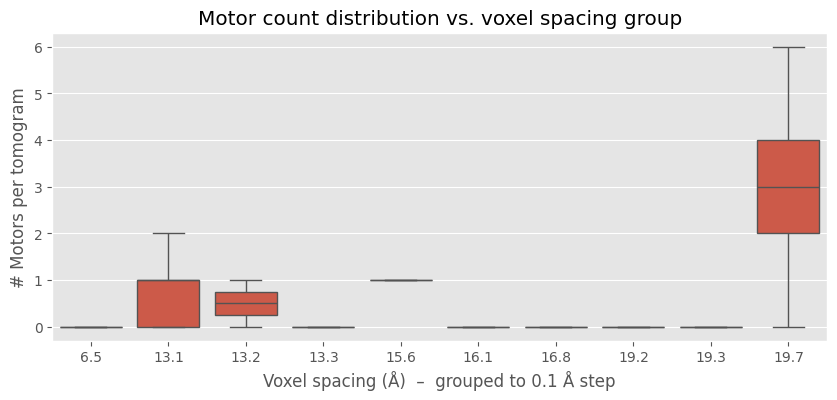

In [23]:
# ─── prerequisites ───────────────────────────────────────────────
from pathlib import Path
import pandas as pd, numpy as np, torch, zarr, seaborn as sns, matplotlib.pyplot as plt
from IPython.display import display      # Jupyter 에서 테이블 예쁘게 보려고

# ↓ 학습-모델 import 는 나중 분석 단계에서만 필요하면 그때 다시 불러오세요
# from metrics.metric_motor import fbeta_pixel
# from models.flexible_unet_motor import Net, to_ce_target

LABEL_CSV = Path(r"D:/project/Kaggle/BYU/byu-motor/data/raw/train_labels.csv")
ZARR_DIR  = Path(r"D:/project/Kaggle/BYU/byu-motor/data/processed/zarr/train")

df = pd.read_csv(LABEL_CSV)

# ─── A) 그룹 정의 ────────────────────────────────────────────────
df["spacing_grp"] = df["Voxel spacing"].round(1)
df["res_grp"]     = df.apply(
    lambda r: f"{int(r['Array shape (axis 1)'])}×{int(r['Array shape (axis 2)'])}", axis=1
)

# ─── B) 그룹별 모터 밀도 요약 ────────────────────────────────────
for col in ["spacing_grp", "res_grp"]:
    g = (
        df.groupby(col)
          .agg(n_tomo=("tomo_id", "nunique"),
               mean_motor=("Number of motors", "mean"))
          .sort_index()
    )
    print(f"\n=== {col} ===")
    display(g)

# (선택) 시각화
plt.figure(figsize=(10,4))
sns.boxplot(x="spacing_grp", y="Number of motors", data=df, showfliers=False)
plt.xlabel("Voxel spacing (Å)  –  grouped to 0.1 Å step")
plt.ylabel("# Motors per tomogram")
plt.title("Motor count distribution vs. voxel spacing group")
plt.show()


test 해상도 확인

In [24]:
import cv2
from pathlib import Path
from collections import Counter

# ────────────────────────────────────────────────────────────────
TEST_ROOT = Path(r"D:/project/Kaggle/BYU/byu-motor/data/raw/test")  # ← 수정
assert TEST_ROOT.exists(), f"{TEST_ROOT} not found"

xy_sizes = []
print(f"{'tomo_id':<20}  H×W")
print("-" * 32)

for tomo_dir in sorted(TEST_ROOT.iterdir()):
    if not tomo_dir.is_dir():
        continue

    # 슬라이스 하나만 읽으면 충분 (가장 앞쪽 파일)
    first_jpg = next(tomo_dir.glob("*.jpg"))
    img = cv2.imread(str(first_jpg), cv2.IMREAD_UNCHANGED)
    h, w = img.shape[:2]
    xy_sizes.append(f"{h}×{w}")
    print(f"{tomo_dir.name:<20}  {h}×{w}")

# ─ 요약 ─────────────────────────────────────────────────────────
print("\n=== distribution ===")
cnt = Counter(xy_sizes)
for size, n in cnt.items():
    print(f"{size:<10} : {n} tomograms")


tomo_id               H×W
--------------------------------
tomo_003acc           1912×1847
tomo_00e047           959×928
tomo_01a877           960×928

=== distribution ===
1912×1847  : 1 tomograms
959×928    : 1 tomograms
960×928    : 1 tomograms


해상도별 voxel spacing 분포

In [26]:
# ▣ 셀: 해상도-별 spacing 분포
import pandas as pd
from pathlib import Path

LABEL_CSV = r"D:\project\Kaggle\BYU\byu-motor\data\raw\train_labels.csv"    # 경로 맞게 조정
df = pd.read_csv(LABEL_CSV)

# ─ ① XY 해상도 문자열 생성 ──────────────────────────────
df["res"] = df.apply(
    lambda r: f"{int(r['Array shape (axis 1)'])}×{int(r['Array shape (axis 2)'])}",
    axis=1,
)

# ─ ② tomogram 단위(unique)로 집계  ─────────────────────
#   ‣ 하나의 tomo_id 가 여러 motor row 를 가질 수 있으므로
#     tomo_id 단위로 중복 제거 후 매칭
uniq = (df[["tomo_id", "res", "Voxel spacing"]]
        .drop_duplicates()
        .reset_index(drop=True))

# ─ ③ pivot-table: 해상도×spacing 카운트 ───────────────
pivot = (
    uniq.pivot_table(index="res",
                     columns="Voxel spacing",
                     values="tomo_id",
                     aggfunc="nunique",
                     fill_value=0)
      .sort_index()
      .sort_index(axis=1)
)

print("▶︎ 해상도별 Voxel-spacing 카운트(tomogram 수)\n")
display(pivot)

# (원하면 csv로 저장)
# pivot.to_csv("res_spacing_counts.csv")


▶︎ 해상도별 Voxel-spacing 카운트(tomogram 수)



Voxel spacing,6.5,13.1,13.2,13.3,15.6,16.1,16.8,19.2,19.3,19.7
res,,,,,,,,,,
1024×1440,0,0,0,18,0,0,0,0,0,0
1912×1847,3,0,0,0,0,0,0,0,0,0
924×956,0,0,0,0,0,16,0,0,0,49
927×959,0,11,0,0,0,0,0,0,0,0
928×928,0,27,2,0,19,0,13,0,10,0
928×960,0,80,0,0,0,22,0,0,0,0
956×924,0,0,0,0,0,1,0,0,0,0
959×928,0,0,0,0,70,0,0,0,0,0
960×928,0,145,0,0,82,1,72,7,0,0


space group별 motor 개수

In [28]:
from pathlib import Path
import pandas as pd

# ── 데이터 로드 & spacing 그룹 생성 ──────────────────────────
df = pd.read_csv(r"D:/project/Kaggle/BYU/byu-motor/data/raw/train_labels.csv")
df["spacing_grp"] = df["Voxel spacing"].round(1)      # 13.05 → 13.1

# ── ① 그룹별 기본 통계 (n_tomo / n_motor / mean_motor) ────
agg = (df.groupby("spacing_grp")
         .agg(n_tomo     = ("tomo_id", "nunique"),
              n_motor    = ("Number of motors", "sum"),
              mean_motor = ("Number of motors", "mean"))
      )

# ── ② 모터 ≥1 tomogram 비율 계산 ─────────────────────────
tomo_has_motor = (df.drop_duplicates("tomo_id")          # tomogram 당 1행
                    .assign(has=lambda d: (d["Number of motors"] > 0).astype(int))
                    .groupby("spacing_grp")["has"]
                    .sum())

agg["tomo_has_motor_%"] = 100 * tomo_has_motor / agg["n_tomo"]
agg = agg.reset_index().sort_values("spacing_grp")

display(agg)


,spacing_grp,n_tomo,n_motor,mean_motor,tomo_has_motor_%
0,6.5,3,0,0.000000,0.000000
1,13.1,263,353,1.213058,67.300380
2,13.2,2,1,0.500000,50.000000
3,13.3,18,0,0.000000,0.000000
4,15.6,171,155,0.875706,78.947368
5,16.1,40,0,0.000000,0.000000
6,16.8,85,18,0.211765,21.176471
7,19.2,7,0,0.000000,0.000000
8,19.3,10,0,0.000000,0.000000
9,19.7,49,304,2.923077,63.265306
